In [19]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 5)  #set default figure size
import numpy as np
import quantecon as qe
from quantecon.distributions import BetaBinomial

from numba import jit, float64
from numba.experimental import jitclass

## Discrete State Dynamic Programming

In this lecture, we have a peek on Discrete State Dynamic Programming.

Discrete State Dynamic Programming analyzes how an agent makes optimal decisions when faced with discrete choices (discrete policy functions) and uncertainty in dynamic programming.

To facilitate understanding, we begin with a classic model from labor economics, the McCall model, as an example.  
**(In future lectures, we will see its application in more scenarios.)**

- Although we use the McCall model as an introduction, such models are not limited to labor economics. Other contexts, such as:
  1. A country's **strategic default decisions** (whether to default, and if so, whether to engage in renegotiation),
  2. An individual's decision to leave a current job offer to participate in a vocational training program,
  3. **Discrete dynamic games**,
  4. **Consumer behavior under liquidity constraints**,
  5. etc...
  
  can all be analyzed using the same algorithm.

### **Special Characteristics of Discrete Choice Dynamic Programming**
1. The policy function is discrete, so the optimal objective function is non-differentiable.  
  This means that **Euler equations and differential equations cannot be used** for analysis.

2. The objective function, state variable space, and probability space can vary significantly across different scenarios.   
  This implies that there is no universal package like Dynare to analyze these problems, creating **higher barriers to entry**.

### **Universality of Discrete Choice Models**
1. By refining the policy function, **discrete choice models can approximate continuous choice models**.
2. They can **be solved using general dynamic programming methods**, such as value function iteration and policy function iteration.
   
   Therefore, discrete choice models can be considered the foundation for all dynamic programming models.

### **Fundamental Elements of Discrete Choice Models**
1. Discrete state space and discrete choices (actions)
2. Infinite horizon
3. Discounted rewards
4. Markov state transitions (option)


## contents (still under progress)
- [Introduction of the McCall search model](#Introduction-of-mccall-search-model)
- [McCall model](#the-mccall-model)
- [The value function](#the-value-function)
- [Computing the Optimal Policy](#computing-the-optimal-policy)
- [The optimal policy](#the-optimal-policy)
- [The Algorithm](#the-algorithm)
- [Implementation](#implementation)
- [Comparative Statics](#comparative-statics)
- [Simulation by the policy function](#simulation-by-the-policy-function)

### Introduction of McCall search model

McCall(1970) helped transform economists’ way of thinking about labor markets.

To clarify notions such as “involuntary” unemployment, McCall modeled the decision problem of an unemployed worker  in terms of factors including

- current and likely future wages  
- impatience  
- unemployment compensation  

To solve the decision problem McCall used dynamic programming.

### The McCall model

**environment:**
- The offer sequence $ \{w_t\}_{t \geq 0} $ is IID, with $ q(w) $ being the probability of observing wage $ w $ in finite set $ \mathbb{W} $.  
- The agent observes $ w_t $ at the start of $ t $.  
- The agent knows that $ \{w_t\} $ is IID with common distribution $ q $ and can use this when computing expectations.  

At time $ t $, our agent has two choices:

1. Accept the offer and work permanently at constant wage $ w_t $.  
1. Reject the offer, receive unemployment compensation $ c $, and reconsider next period.  


The agent is infinitely lived and aims to maximize the expected discounted
sum of earnings

$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t
$$

The constant $ \beta $ lies in $ (0, 1) $ and is called a **discount factor**.

The smaller is $ \beta $, the more the agent discounts future utility relative to current utility.

The variable  $ y_t $ is income, equal to

- his/her wage $ w_t $ when employed  
- unemployment compensation $ c $ when unemployed  

### The Value Function

let $ v^*(w) $ be the total lifetime *value* accruing to an
unemployed worker who enters the current period unemployed when the wage is
$ w \in \mathbb{W} $.

$ v^*(w) $ denotes the value of the objective function 
when an agent in this situation makes **optimal** decisions now
and at all future points in time.

Think of $ v^* $ as a function that assigns to each possible wage
$ s $ the maximal lifetime value that can be obtained with that offer in
hand.

A crucial observation is that this function $ v^* $ must satisfy the
recursion


<a id='equation-odu-pv'></a>
$$
v^*(w)
= \max \left\{
        \frac{w}{1 - \beta}, \, c + \beta
        \sum_{w' \in \mathbb{W}} v^*(w') q (w')
    \right\} \tag{1}
$$

for every possible $ w $  in $ \mathbb{W} $.

The intuition behind it is as follows:

- the first term inside the max operation is the lifetime payoff from accepting current offer, since  

$$
\frac{w}{1 - \beta} = w + \beta w + \beta^2 w + \cdots
$$

- the second term inside the max operation is the **continuation value**, which is the lifetime payoff from rejecting the current offer and then behaving optimally in all subsequent periods  

If we optimize and pick the best of these two options, we obtain maximal lifetime value from today, given current offer $ w $.

But this is precisely $ v^*(w) $, which is the left-hand side of [(1)](#equation-odu-pv).

### Computing the Optimal Policy

To put the above ideas into action, we need to compute the value function at
each possible state $ w \in \mathbb W $.

To simplify notation, let’s set

$$
\mathbb W := \{w_1, \ldots, w_n  \}
    \quad \text{and} \quad
    v^*(i) := v^*(w_i)
$$

The value function is then represented by the vector
$ v^* = (v^*(i))_{i=1}^n $.

In view of [(1)](#equation-odu-pv), this vector satisfies the nonlinear system of equations


<a id='equation-odu-pv2'></a>
$$
v^*(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v^*(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n
$$

### The Optimal Policy

Suppose for now that we are able to solve [(1)](#equation-odu-pv) for the unknown function $ v^* $.

Once we have this function in hand we can behave optimally (i.e., make the
right choice between accept and reject).

All we have to do is select the maximal choice on the right-hand side of [(1)](#equation-odu-pv).

The optimal action is best thought of as a **policy**, which is, in general, a map from
states to actions.

Given *any* $ w $, we can read off the corresponding best choice (accept or
reject) by picking the max on the right-hand side of [(1)](#equation-odu-pv).

Thus, we have a map from $ \mathbb R $ to $ \{0, 1\} $, with 1 meaning accept and 0 meaning reject.

We can write the policy as follows

$$
\sigma(w) := \mathbf{1}
    \left\{
        \frac{w}{1 - \beta} \geq c + \beta \sum_{w' \in \mathbb W}
        v^*(w') q (w')
    \right\}
$$

Here $ \mathbf{1}\{ P \} = 1 $ if statement $ P $ is true and equals 0 otherwise.

We can also write this as

$$
\sigma(w) := \mathbf{1} \{ w \geq \bar w \}
$$

where


<a id='equation-reswage'></a>
$$
\bar w := (1 - \beta) \left\{ c + \beta \sum_{w'} v^*(w') q (w') \right\} \tag{2}
$$

Here $ \bar w $ (called the *reservation wage*) is a constant depending on
$ \beta, c $ and the wage distribution.

The agent should accept if and only if the current wage offer exceeds the reservation wage.

In view of [(2)](#equation-reswage), we can compute this reservation wage if we can compute the value function.

### The Algorithm

To compute this vector, we use **value function iteration**:

Step 1: pick an arbitrary initial guess $ v \in \mathbb R^n $.

Step 2: compute a new vector $ v' \in \mathbb R^n $ via


<a id='equation-odu-pv2p'></a>
$$
v'(i)
= \max \left\{
        \frac{w(i)}{1 - \beta}, \, c + \beta \sum_{1 \leq j \leq n}
            v(j) q (j)
    \right\}
\quad
\text{for } i = 1, \ldots, n \tag{3}
$$

Step 3: calculate a "distance" between $ v $ and $ v' $, such as $ \max_i |v(i)- v'(i)| $.

Step 4: if the deviation is larger than some fixed tolerance, set $ v = v' $ and go to step 2, else continue.

Step 5: return $ v $.

For a small tolerance $\epsilon$, the returned function $ v $ is a close approximation to the value function $ v^* $.

The theory below elaborates on this point.

### Implementation

Our default for $ q $, the distribution of the state process, will be Beta-binomial.

And the possible value of wage offer(state variable) $w$ is in a range of $[0,60]$.

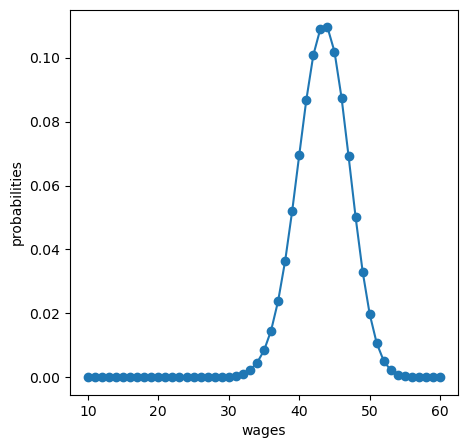

In [20]:
# default for prob density q
n, a, b = 50, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

# default for the possible values of wage
w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

# plot
fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')
plt.show()

Here’s a class that stores the data and computes the values of state-action pairs,
i.e. the value in the maximum bracket on the right hand side of the Bellman equation [(3)](#equation-odu-pv2p),
given the current state and an arbitrary feasible action.
Default parameter values are embedded in the class.

Note that:  
We are going to use Numba to accelerate our code.
The following helps Numba by providing some type

In [21]:
mccall_data = [
    ('β', float64),      # discount factor
    ('c', float64),      # unemployment compensation
    ('w', float64[:]),   # list of wage values
    ('q', float64[:])    # pmf of random variable w
]

@jitclass(mccall_data)
class McCall:
    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):
        self.c , self.β = c,β
        self.w , self.q = w,q
    
    def state_action_values(self, i, v):
        """
        The values of state-action pairs, given arbitrary value function.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        
        # Evaluate value for each state-action pair
        # Consider action = accept or reject the current offer
        accept_value = w[i] / (1 - β)
        reject_value = c + β * np.sum(v * q)

        return np.array([accept_value, reject_value])

Based on these defaults, let’s try plotting the first few approximate value functions
in the sequence $ \{ T^k v \} $.

We will start from guess $ v $ given by $ v(i) = w(i) / (1 - β) $, which is the value of accepting at every given wage.

Here’s a function to implement this:

In [22]:
def plot_value_function_seq(mcm, ax, num_plots=6):
    """
    Plot a sequence of value functions.

        * mcm is an instance of McCallModel
        * ax is an axes object that implements a plot method.

    """

    n = len(mcm.w)
    # initial guess for the value function
    v = mcm.w / (1 - mcm.β)
    v_next = np.empty_like(v)
    
    for i in range(num_plots):
        # plot the value functions in iterations
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        
        # Update guess
        for j in range(n):
            # v_next is the maximum of state-action pair values
            v_next[j] = np.max(mcm.state_action_values(j, v))
        v[:] = v_next  # copy contents into v

    ax.legend(loc='lower right')

Now let’s create an instance of `McCallModel` and watch iterations  $ T^k v $ converge from below:

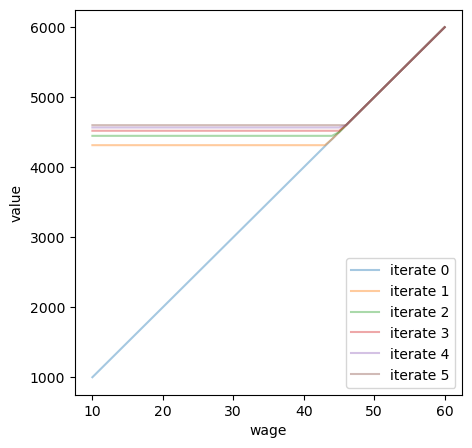

In [23]:
# define the model
mcm = McCall()

# process of iteration
fig, ax = plt.subplots()
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

Let's try to apply the value function iteration

In [24]:
@jit(nopython=True)
def value_iteration(mcm,ε=1e-5,max_iter=500,show_converge=True):
    """
    Value function iteration for McCall search model
    
    Args:
        mcm: 
            model class of McCall
        ε (float):
            tolerance for iteration  
        max_iter (int):
            maximum number of iterations  
    
    Returns:
        w (array):
            list of possible wage offer / state variable  
        v (array):
            value function  
        action (array):
            action/policy function  
        reservation (array):
            reservation wage  
    """

    # parameters of the model
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q
    # initial setting for the iteration
    diff=1000
    iter=0

    # value functions
    v = w/(1-β)                 # initial guess
    v_next = np.zeros_like(v)   
    action = np.zeros_like(w)   # action function

    # Iteration
    while diff>ε and iter<max_iter:
        
        # update value function
        for j,vj in enumerate(v_next):
            v_next[j] = max(mcm.state_action_values(j, v))
            action[j] = 1 - np.argmax(mcm.state_action_values(j,v))
            # if accept action[j]=1
        
        # check the distance between old and new value functions
        diff = np.max(np.abs(v_next - v))
        v[:] = v_next
        iter += 1
        
        if show_converge==True:
            if iter%40 == 0 or diff < 1e-5:
                print(f'iteration: {iter}, error: {diff}')
            if diff < 1e-5:
                print('value function converged successfully')
    
    # calculate the reservation wage
    reservation = (1-β)*(c + β * np.sum(q*v))
    
    return w,v,action,reservation

Apply the value function iteration:

iteration: 40, error: <object type:float64>
iteration: 80, error: <object type:float64>
iteration: 107, error: <object type:float64>
value function converged successfully


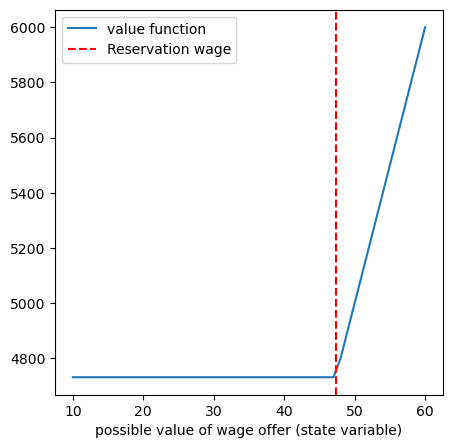

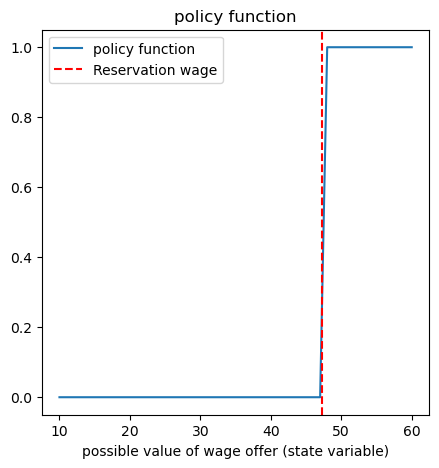

In [25]:
w,v,action,reservation = value_iteration(mcm,ε=1e-5,max_iter=500)

plt.plot(w, v,label="value function")
plt.axvline(x=reservation, color='red', linestyle='--',label="Reservation wage")
plt.xlabel("possible value of wage offer (state variable)")
plt.legend()
plt.show()

plt.plot(w, action,label="policy function")
plt.title("policy function")
plt.axvline(x=reservation, color='red', linestyle='--',label="Reservation wage")
plt.xlabel("possible value of wage offer (state variable)")
plt.legend()
plt.show()

### Comparative Statics

Now that we know how to compute the reservation wage, let’s see how it varies with
parameters.

In particular, let’s look at what happens when we change impatience $ \beta $ and unemployment compensation
$ c $.

In [26]:
grid_size = 25

# matrix of reservation wage
R = np.empty((grid_size, grid_size))
# lists of parameters
c_vals = np.linspace(10.0, 30.0, grid_size) # unemployment compensation
β_vals = np.linspace(0.9, 0.99, grid_size) # impatience

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        # substitute c and β into McCal model
        mcm = McCall(c=c, β=β)
        # save reservation wages into matrix R
        _,_,_,R[i, j] = value_iteration(mcm,show_converge=False) 

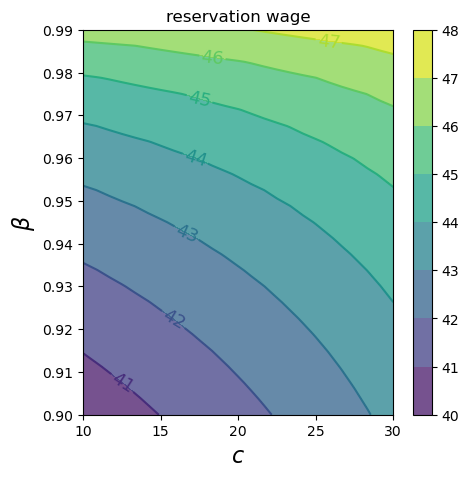

The reservation wage increases both with patience and with unemployment compensation.


In [27]:
# Draw the graph
fig, ax = plt.subplots()

# Plot filled contour lines (contourf) using c_vals and β_vals as axes, and R.T as the data.
# The alpha parameter controls the transparency of the filled contours.
cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
# Plot contour lines (without filling).
ctr1 = ax.contour(c_vals, β_vals, R.T)

# Add labels to the contour lines. `inline=1` places labels inline with the contour lines.
plt.clabel(ctr1, inline=1, fontsize=13)
# Add a colorbar to the plot for the filled contours, showing the mapping of data values to colors.
plt.colorbar(cs1, ax=ax)

ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)
# Disable the use of offset notation for tick labels
ax.ticklabel_format(useOffset=False)
plt.show()

print('The reservation wage increases both with patience and with unemployment compensation.')

### Simulation by the policy function

By using the policy function (action function), we can simulate individual behavior. Here, we analyze the relationship between the average search time and other parameters through the model.

First, we define a function to calculate the search time for a single simulation.


In [28]:
# The first function use reservation wage as stop criteria
def stop_time1(w_default,q_default,reservation,seed=1234):
    """
    simulate stop searching time
    
    Args:
        w_default (array): possible values of wage offer
        q_default (array): distribution of wage offer
        reservation (array): reservation wage 

    Returns:
        t (int): searching time
    """
    cdf = np.cumsum(q_default)
    # initial searching time
    t=0
    np.random.seed(seed)

    while True:
        wage_offer = w_default[qe.random.draw(cdf)] # draw a random wage offer
        if wage_offer > reservation:
            stop_time = t
            break
        else:
            t += 1
             
    return stop_time

# The second funciton use policy functio to calculate stop criteria
def stop_time2(w_default,q_default,policy_fun,seed=1234):
    """
    simulate stop searching time
    
    Args:
        w_default (array): possible values of wage offer
        q_default (array): distribution of wage offer
        policy_fun (array): policy funciton 

    Returns:
        t (int): searching time
    """
    cdf = np.cumsum(q_default)
    # initial searching time
    t=0
    np.random.seed(seed)

    while True:
        wage_offer = w_default[qe.random.draw(cdf)] # draw a random wage offer
        a = np.interp(wage_offer,w_default,policy_fun)
        if a>=0.9 :
            stop_time = t
            break
        else:
            t += 1
             
    return stop_time

Next, we define a function to calculate the average search time over 1,000 simulations.

In [29]:
def mean_stop_time(w_default,q_default,policy_fun,num_reps=1000):
    """
    Simulate average search time
    
    Args:
        w_default (array): possible values of wage offer
        q_default (array): distribution of wage offer
        policy_fun (array): policy funciton 
    
    Returns:
        mean (float): mean simulated search time
    """
    stop_time_list = []
    
    for i in range(num_reps):
        t = stop_time2(w_default,q_default,policy_fun,seed=i)
        stop_time_list.append(t)
    
    mean = np.mean(stop_time_list)

    return mean

Finally, we iterate over the unemployment compensation values to calculate the average search time corresponding to each compensation level.

In [30]:
# lists of unemployment compensation
c_vals = np.linspace(10, 40, 25) 
stop_times = np.zeros_like(c_vals)

for i, c in enumerate(c_vals):
    # construct the model
    mcm = McCall(c=c)
    # value function iteration
    _,_,action,_ = value_iteration(mcm,show_converge=False)
    # save average search time
    avg = mean_stop_time(w_default,q_default,action)
    stop_times[i] = avg

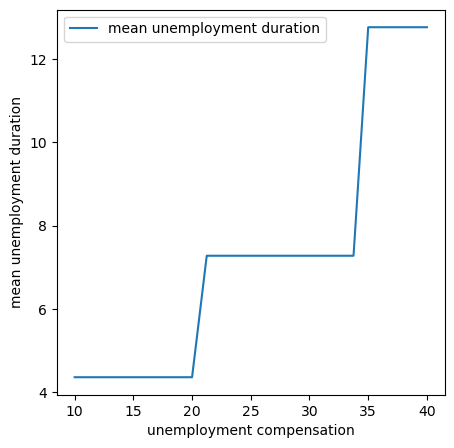

In [31]:
fig,ax = plt.subplots()
ax.plot(c_vals,stop_times,label="mean unemployment duration")
ax.set(xlabel="unemployment compensation",ylabel="mean unemployment duration")
ax.legend()
plt.show()